# What we're going to cover

* Using TensorFlow Datasets to download and explore data
* Creating preprocessing function for our data
* Batching & preparing datasets for modelling (making our datasets run fast)
* Creating modelling callbacks
* Setting up mixed precision training
* Building a feature extraction model
* Fine-tuning the feature extraction model
* Viewing training results on TensorBoard

Alongside attempting to beat the DeepFood paper, we're going to learn about two methods to significantly improve the speed of our model training:

1. Prefetching
2. Mixed precision training

In [ ]:
# Check GPU
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-09accfb4-fd99-7087-f2ad-e71ce1b8f618)


In [ ]:
# Check tensorflow version
import tensorflow as tf
tf.__version__

'2.6.0'

## Get helper function

In [ ]:
# Get helper functions file
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-09-17 03:22:57--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-09-17 03:22:57 (85.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import serires of helper function
from helper_functions import plot_loss_curves, unzip_data, walk_through_dir, create_tensorboard_callback, compare_historys

# Using TensorFlow DataSets to download data

In [ ]:
# Get tensorflow datasets
import tensorflow_datasets as tfds

In [ ]:
datasets_list = tfds.list_builders()
print("food101" in datasets_list)

True


In [ ]:
# Load in the data (take about 5-6 mins)
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train","validation"],
                                             shuffle_files = True,
                                             as_supervised=True,
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteAO6ZK2/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteAO6ZK2/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [ ]:
# Features of food101 TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [ ]:
# Get class names
class_names = ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

# Exploring the Food101 data from TensorFlow Datasets

In [ ]:
# take on sample of the training data
train_one_sample = train_data.take(1)

In [ ]:
# What does one sample of our training data look like
train_one_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [ ]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape},
  Image dtype: {image.dtype},
  Target class from Food101 (Tensor Form): {label},
  Class name (str form): {class_names[label.numpy()]}
  """)


  Image shape: (512, 384, 3),
  Image dtype: <dtype: 'uint8'>,
  Target class from Food101 (Tensor Form): 55,
  Class name (str form): hot_dog
  


In [ ]:
# What does an image tensorf form TFDS's food 101 look like

image

<tf.Tensor: shape=(512, 384, 3), dtype=uint8, numpy=
array([[[  1,   1,   1],
        [  1,   1,   1],
        [  1,   1,   1],
        ...,
        [104, 115, 121],
        [129, 140, 144],
        [119, 130, 134]],

       [[  1,   1,   1],
        [  1,   1,   1],
        [  1,   1,   1],
        ...,
        [117, 128, 134],
        [139, 150, 154],
        [142, 153, 157]],

       [[  1,   1,   1],
        [  1,   1,   1],
        [  1,   1,   1],
        ...,
        [143, 154, 160],
        [144, 155, 159],
        [134, 145, 149]],

       ...,

       [[130,  27,  22],
        [130,  27,  22],
        [131,  26,  22],
        ...,
        [160,  53,  73],
        [160,  53,  73],
        [158,  51,  71]],

       [[130,  26,  23],
        [130,  26,  23],
        [131,  26,  23],
        ...,
        [160,  52,  75],
        [159,  51,  74],
        [156,  48,  71]],

       [[130,  26,  25],
        [130,  26,  25],
        [131,  25,  25],
        ...,
        [157,  49,  7

In [ ]:
tf.reduce_max(image), tf.reduce_min(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=255>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=0>)

# Plot an image from TensorFlow Datasets

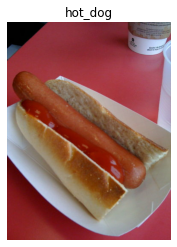

In [ ]:
# Plot on image tensor
import matplotlib.pyplot as plt

plt.imshow(image)
plt.title(class_names[label])
plt.axis(False);

# Create preprocessing functions for our data

>🔑 Note: Pretrained EfficientNetBX models in tf.keras.applications.efficientnet (what we're going to be using) have rescaling built-in. But for many other model architectures you'll want to rescale your data (e.g. get its values between 0 & 1). This could be incorporated inside your "preprocess_img()" function (like the one below) or within your model as a `tf.keras.layers.experimental.preprocessing.Rescaling` layer.

In [ ]:
# Make a function for preprocessing images

def preprocess_img(image, label, img_size=224):
  img = tf.image.resize(image, [img_size, img_size])
  return tf.cast(img, dtype=tf.float32), label

In [ ]:
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n{image[:2]}...\n,Shape {image.shape},\nDatatype: {image.dtype}\n")

print(f"Image after preprocessing:\n{preprocessed_img[:2]}\n, Shape {preprocessed_img[:2].shape}, \nDatatype {preprocessed_img.dtype}\n")

Image before preprocessing:
[[[  1   1   1]
  [  1   1   1]
  [  1   1   1]
  ...
  [104 115 121]
  [129 140 144]
  [119 130 134]]

 [[  1   1   1]
  [  1   1   1]
  [  1   1   1]
  ...
  [117 128 134]
  [139 150 154]
  [142 153 157]]]...
,Shape (512, 384, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
[[[  1.         1.         1.      ]
  [  1.         1.         1.      ]
  [  1.         1.         1.      ]
  ...
  [107.79069  120.3621   127.93351 ]
  [111.209465 122.209465 128.20946 ]
  [134.37245  145.37245  149.37245 ]]

 [[  1.         1.         1.      ]
  [  1.         1.         1.      ]
  [  1.         1.         1.      ]
  ...
  [126.44904  139.02045  146.59186 ]
  [131.88774  142.88774  148.88774 ]
  [115.81641  126.81641  130.8164  ]]]
, Shape (2, 224, 3), 
Datatype <dtype: 'float32'>



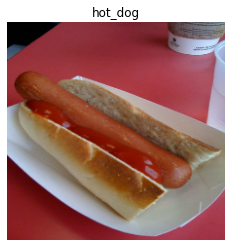

In [ ]:
# We can still plot our preprocessed images as long as we divide by 255
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label])
plt.axis(False);

# Batch & prepare datasets
    Original dataset (e.g. train_data) -> map() -> shuffle() -> batch() -> prefetch() -> PrefetchDataset



In [ ]:
# Map preprocessing function to training data ( and paralellize )
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE) #  parallelize preprocessing and improve speed

# Shuffle train data turn it into batches and prefetch it ( load it faster )
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

# Turn test data into batches (dont shuffle)
test_data = test_data.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
train_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

> 🔑 Note: You can get away without calling the prefetch() method on the end of your datasets, however, you'd probably see significantly slower data loading speeds when building a model. So most of your dataset input pipelines should end with a call to prefecth().

# Creating model callbacks

To do each of these we'll use the following callbacks:
* `tf.keras.callbacks.TensorBoard()`
* `tf.keras.callbacks.ModelCheckpoint()`

In [ ]:
# Create TensorBoard callbacks
from helper_functions import create_tensorboard_callback

# Create modelcheckpoint call back to save model's progress
checkpoint_path = "model_checkpoints/cp.ckpt" # Saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_weights_only=True,
                                                      save_best_only=True,
                                                      monitor="val_acc",
                                                      verbose=0)

# Setup mixed precision training

The beautiful thing is, the `tensorflow.keras.mixed_precision` API has made it very easy for us to get started.

First, we'll import the API and then use the `set_global_policy()` method to set the dtype policy to "mixed_float16".

In [ ]:
# Turn on mixed precesion training
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy(policy="mixed_float16")

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla K80, compute capability 3.7
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla K80, compute capability 3.7
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [ ]:
mixed_precision.global_policy()

<Policy "mixed_float16">

# Build feature extraction model

> 🔑 Note: Since we're using mixed precision training, our model needs a separate output layer with a hard-coded dtype=float32, for example, layers.Activation("softmax", dtype=tf.float32). This ensures the outputs of our model are returned back to the float32 data type which is more numerically stable than the float16 datatype (important for loss calculations). See the "Building the model" section in the TensorFlow mixed precision guide for more.

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create Function model
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models has rescaling buit-in
# x = preprocessing.Rescaling(1./255)(x)
x = base_model(inputs, training= False)
x = tf.keras.layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x)

# Seperate activation of output layer
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when label is not one hot encoded
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

16719872/16705208 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
pooling_layer (GlobalAverage (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


# Checking layer dtype polices ( are we using mixed precision? )

In [ ]:
# Check the dtype policy attributes of layers in our model
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


> 🔑 Note: A layer can have a dtype of float32 and a dtype policy of "mixed_float16" because it **stores its variables** (weights & biases) in float32 (more numerically stable), however it **computes in float16** (faster).

In [ ]:
# Check the layers in the base model and see what dtype and dtype policy
for layer in model.layers[1].layers[:20]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False flo

# Fit the feature extraction model

In [ ]:
# Fit the model with callbacks
history_101_food_classes_feature = model.fit(train_data,
                                             epochs=3,
                                             steps_per_epoch=len(train_data),
                                             validation_data=test_data,
                                             validation_steps=int(0.15*len(test_data)),
                                             callbacks=[create_tensorboard_callback("training loss", "efficientNetB0_101_classes_all_data_feature_extract"), model_checkpoint])

Saving TensorBoard log files to: training loss/efficientNetB0_101_classes_all_data_feature_extract/20210917-043538
Epoch 1/3


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


2368/2368 [==============================] - 316s 116ms/step - loss: 1.8211 - accuracy: 0.5560 - val_loss: 1.2355 - val_accuracy: 0.6700


Epoch 2/3
2368/2368 [==============================] - 266s 111ms/step - loss: 1.2945 - accuracy: 0.6655 - val_loss: 1.1255 - val_accuracy: 0.6928


Epoch 3/3
2368/2368 [==============================] - 266s 111ms/step - loss: 1.1425 - accuracy: 0.7019 - val_loss: 1.0953 - val_accuracy: 0.7060


In [ ]:
# Evaluate model (unsaved version) on whole test
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 85s 108ms/step - loss: 1.0900 - accuracy: 0.7050


[1.0900386571884155, 0.7049505114555359]

# Prepareing our model's layers for fine-tuning


In [ ]:
# Download the saved model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip

--2021-09-17 04:53:09--  https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.133.128, 74.125.140.128, 108.177.15.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.133.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16976857 (16M) [application/zip]
Saving to: ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’

07_efficientnetb0_f 100%[===================>]  16.19M  28.1MB/s    in 0.6s    

2021-09-17 04:53:11 (28.1 MB/s) - ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’ saved [16976857/16976857]



In [ ]:
# Unzip the saved model downloaded from google Storage
!mkdir downloaded_gs_model # Create new dir to store downloaded
!unzip "07_efficientnetb0_feature_extract_model_mixed_precision.zip" -d downloaded_gs_model

Archive:  07_efficientnetb0_feature_extract_model_mixed_precision.zip
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.data-00000-of-00001  
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.index  
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/saved_model.pb  
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/assets/


In [ ]:
# Load and evaluate the downloaded gs model
loaded_gs_model = tf.keras.models.load_model("/content/downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision")

In [ ]:
loaded_gs_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
pooling_layer (GlobalAverage (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
# How does the loaded model perform?
loaded_gs_model.evaluate(test_data)

790/790 [==============================] - 82s 101ms/step - loss: 1.0881 - accuracy: 0.7067


[1.088091492652893, 0.7066534757614136]

In [ ]:
# Check the layers in model freeze or not
for layer in loaded_gs_model.layers:
  layer.trainable = True # Set all to trainable
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)


input_layer True float32 <Policy "float32">
efficientnetb0 True float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [ ]:
# Check the layers in the base model and see what dtype policy
for layer in loaded_gs_model.layers[1].layers[:20]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling True float32 <Policy "mixed_float16">
normalization True float32 <Policy "float32">
stem_conv_pad True float32 <Policy "mixed_float16">
stem_conv True float32 <Policy "mixed_float16">
stem_bn True float32 <Policy "mixed_float16">
stem_activation True float32 <Policy "mixed_float16">
block1a_dwconv True float32 <Policy "mixed_float16">
block1a_bn True float32 <Policy "mixed_float16">
block1a_activation True float32 <Policy "mixed_float16">
block1a_se_squeeze True float32 <Policy "mixed_float16">
block1a_se_reshape True float32 <Policy "mixed_float16">
block1a_se_reduce True float32 <Policy "mixed_float16">
block1a_se_expand True float32 <Policy "mixed_float16">
block1a_se_excite True float32 <Policy "mixed_float16">
block1a_project_conv True float32 <Policy "mixed_float16">
block1a_project_bn True float32 <Policy "mixed_float16">
block2a_expand_conv True float32 <Policy "mixed_float16">
block2a_expand_bn True float32 <Policy "mixed_float

> 🔑 Note: If you've got a small amount of data (less than 100 images per class), you may want to only unfreeze and fine-tune a small number of layers in the base model at a time. Otherwise, you risk overfitting.

# A Couple more callbacks

In [ ]:
# Setup EarlyStopping callback to stop trianing if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=3)

# Create model checkpoint callback to save best model during fine-tuning
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

In [ ]:
# Creating learning rate reductions callabck
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.2, # multiply the lr by 0.2 ( reduce by 5x)
                                                 patience=0.2,
                                                 verbose=1, # print out when lr goes down
                                                 min_lr=1e-7)

In [ ]:
# Compile the model
loaded_gs_model.compile(loss="sparse_categorical_crossentropy",
                        optimizer=tf.keras.optimizers.Adam(0.0001),
                        metrics=["accuracy"])

🔑 Note: Running the cell below will set the model up to fine-tune all of the pre-trained weights in the base model on all of the Food101 data. Doing so with unoptimized data pipelines and without mixed precision training will take a fairly long time per epoch depending on what type of GPU you're using (about 15-20 minutes on Colab GPUs). But don't worry, the code we've written above will ensure it runs much faster (more like 4-5 minutes per epoch).

In [ ]:
# Start to fine tune ( all layers )
history_101_food_classes_all_data_fine_tune = loaded_gs_model.fit(train_data,
                                                                  epochs=100,
                                                                  steps_per_epoch=len(train_data),
                                                                  validation_data=test_data,
                                                                  validation_steps=int(0.15*len(test_data)),
                                                                  callbacks=[create_tensorboard_callback("training_logs", "EfficientNetB0_101_classes_all_data_Fine_tuning"),
                                                                             model_checkpoint, early_stopping, reduce_lr])

Saving TensorBoard log files to: training_logs/EfficientNetB0_101_classes_all_data_Fine_tuning/20210917-051125
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


2368/2368 [==============================] - 1206s 495ms/step - loss: 0.9244 - accuracy: 0.7505 - val_loss: 0.8004 - val_accuracy: 0.7738
INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
2368/2368 [==============================] - 1153s 486ms/step - loss: 0.5780 - accuracy: 0.8396 - val_loss: 0.7701 - val_accuracy: 0.7905
INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/100
2368/2368 [==============================] - 1154s 486ms/step - loss: 0.3303 - accuracy: 0.9065 - val_loss: 0.8801 - val_accuracy: 0.7799

Epoch 00003: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
Epoch 4/100
2368/2368 [==============================] - 1164s 491ms/step - loss: 0.0865 - accuracy: 0.9791 - val_loss: 0.9332 - val_accuracy: 0.8040

Epoch 00004: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
Epoch 5/100
2368/2368 [==============================] - 1163s 490ms/step - loss: 0.0353 - accuracy: 0.9940 - val_loss: 1.0137 - val_accuracy: 0.8006

Epoch 00005: ReduceLROnPlateau reducing learning rate to 7.999999979801942e-07.


In [ ]:
# Save model
loaded_gs_model.save("/content/drive/MyDrive/tensorflow_course/food_vision/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/")


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow_course/food_vision/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow_course/food_vision/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
# Evaluate model ( this should beat DeepFood's 7.4% top-1 accuracy)
loaded_gs_model.evaluate(test_data)

790/790 [==============================] - 80s 101ms/step - loss: 0.9997 - accuracy: 0.8001


[0.9997106790542603, 0.8000792264938354]

## View training results on TensorBoard

In [ ]:
!tensorboard dev upload --logdir ./training_logs \
  --name "Fine-Tuning EfficientNetB0 on all Food101 Data"\
  --description "Training results for fine-tuning EfficientNetB0 on food101 Data with lr 0.0001"\
  --one_shot

2021-09-17 06:59:39.623145: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-17 06:59:39.730328: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-17 06:59:39.731038: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./training_logs

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy 

In [ ]:
from helper_functions import pred_and_plot, load_and_prep_image


In [ ]:
image = load_and_prep_image("/content/drive/MyDrive/R.jpg", img_shape = 224, scale=True)
pred_probs = loaded_gs_model.predict(tf.expand_dims(image, axis=0))
pred_classnames = class_names[pred_probs.argmax()]
pred_classnames

'breakfast_burrito'